In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.3: Bayesian linear regression



## Example (Linear)
Let's start with a simple example where we just have to find a linear fit.
Here are some synthetic data:

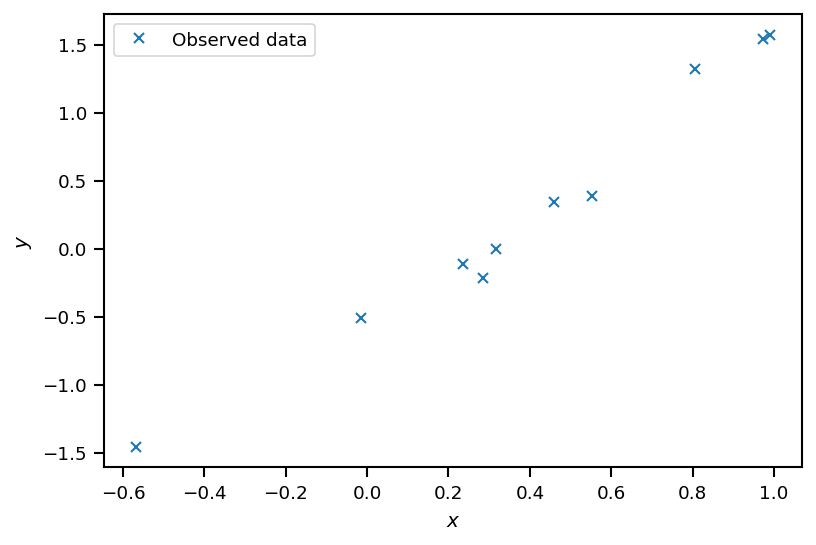

In [2]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [3]:
# function to get Polynomial features
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

We saw that for Gaussian likelihood and weightp prior, the posterior of the weights is Gaussian:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{S}\right),
$$
where
$$
\mathbf{S} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1},
$$
and
$$
\mathbf{m} = \sigma^{-2}\mathbf{S}\Phi^T\mathbf{y}_{1:n}.
$$
Let's write some code that finds the posterior weight mean vector $\mathbf{m}$ and the posterior weight covariance matrix $\mathbf{S}$:

In [4]:
# I need this to take the Cholesky decomposition
import scipy

def find_m_and_S(Phi, y, sigma2, alpha):
    """
    Return the posterior mean and covariance of the weights of a Bayesian linear regression problem with
    design matrix ``Phi`` observed targets ``y``, noise variance ``sigma2``
    and priors for the weights ``alpha``.
    """
    A = np.dot(Phi.T, Phi) / sigma2 + alpha * np.eye(Phi.shape[1])
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(L, np.dot(Phi.T, y / sigma2))
    S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))
    return m, S

Let's apply this to the synthetic dataset.

In [5]:
import scipy.stats as st

# Select polynomial degree and get design matrix
degree = 1
# The design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

# We need to pick variance by hand for now (here I am using the true one)
sigma2 = 0.1 ** 2
# We also need to pick the regularization parameter by hand:
alpha = 5.0
# Here is the prior for the weights as a distribution:
w_prior = st.multivariate_normal(mean=np.zeros(degree+1), cov=alpha * np.eye(degree+1))
# Get the posterior mean and covariance for the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights as a distribution:
w_post = st.multivariate_normal(mean=m, cov=S)

Now let's plot contours of the prior and the posterior.

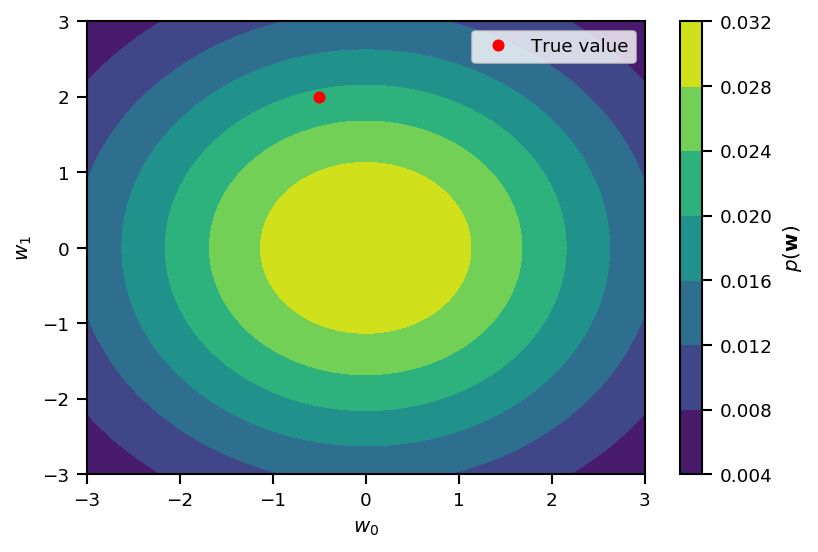

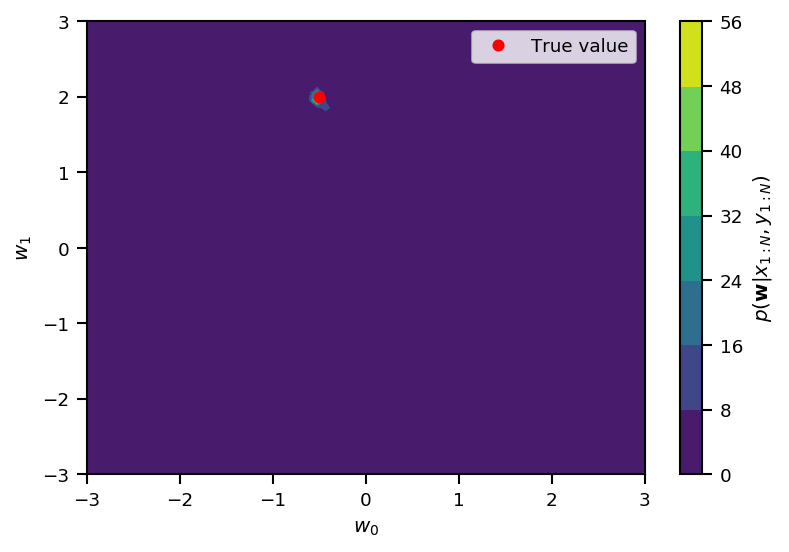

In [6]:
# Plot the contours of the prior and the posterior
fig, ax = plt.subplots(dpi=150)
ws = np.linspace(-3.0, 3.0, 64)
W1, W2 = np.meshgrid(ws, ws)
w_all = np.hstack([W1.flatten()[:, None], W2.flatten()[:, None]])
W_prior_pdf = w_prior.pdf(w_all).reshape(W1.shape)
c = ax.contourf(W1, W2, W_prior_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w})$');

# Plot the posterior
fig, ax = plt.subplots(dpi=150)
W_post_pdf = w_post.pdf(w_all).reshape(W1.shape)
c = ax.contourf(W1, W2, W_post_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w}|x_{1:N}, y_{1:N})$');

Let's visualize some prior samples of the weights.
What we do below is just sampling from the prior of the weights and drawing the line that corresponds to each sample. Notice that the lines are all over the place. Some have positive slope. Some are negative slope. Some cut the x-axis and some don't. That's fine. We have so much uncertainty because we haven't seen the data yet.

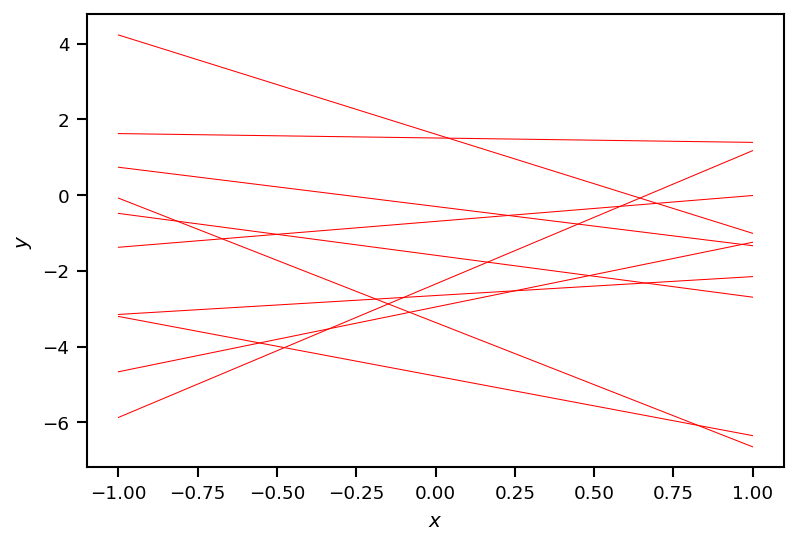

In [7]:
# Prior samples
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_prior.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Now let's do the same thing, but instead of sampling the weights from the prior, let's sample them from the posterior.
Notice that we there is much less (epistemic) uncertainty now that we are taking the data into account.

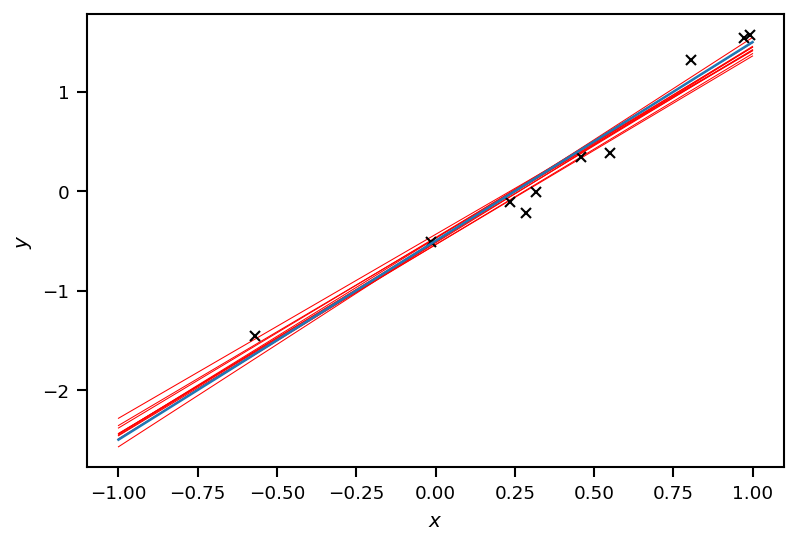

In [8]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case?

## Example (Quadratic)

Let's repeat what we did above with a quadratic example.
Here are some synthetic data:

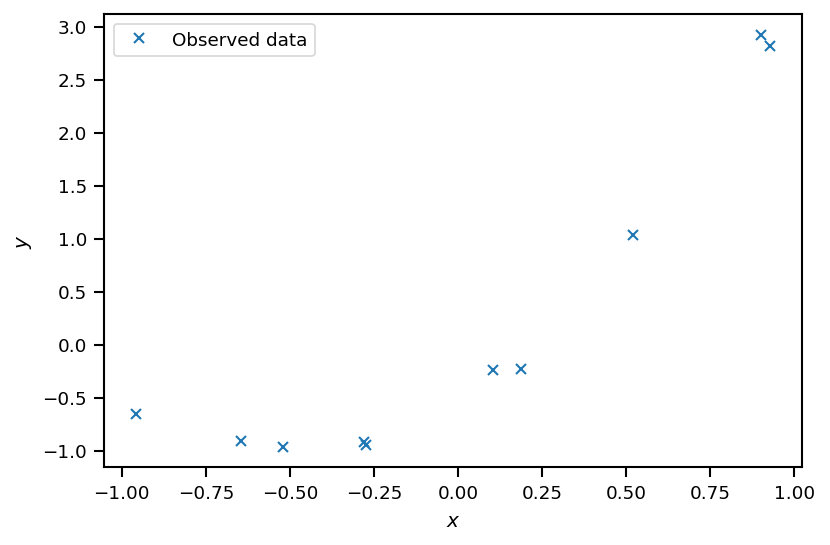

In [9]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Here is how we fit a $7$ degree polynomial:

In [10]:
# Select polynomial degree and get design matrix
degree = 7
Phi = get_polynomial_design_matrix(x[:, None], degree)# Pick variance (here I am using the true one)
sigma2 = 0.1 ** 2
# Pick the regularization parameter:
alpha = 5.0
# The prior for the weights
w_prior = st.multivariate_normal(mean=np.zeros(degree+1), cov=alpha * np.eye(degree+1))
# Solve for the MAP of the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights
w_post = st.multivariate_normal(mean=m, cov=S)

Let's visualize some samples from the prior:

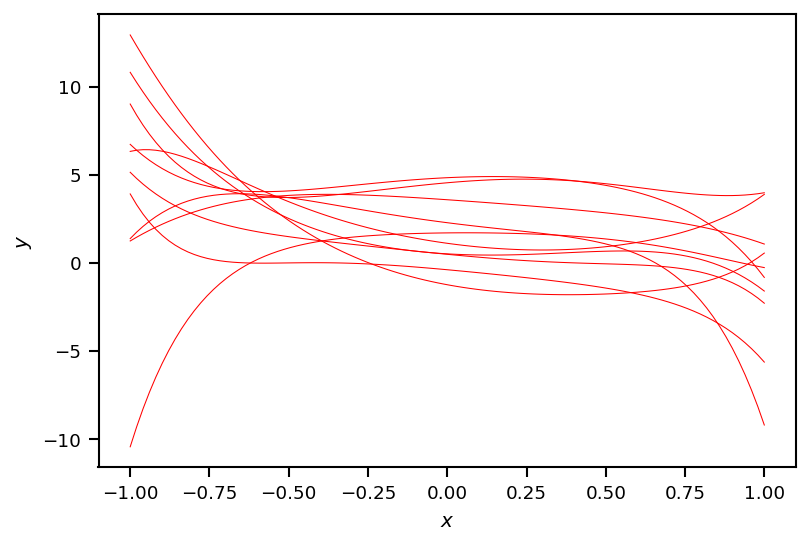

In [11]:
# Prior samples
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_prior.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's visualize some samples from the posterior:

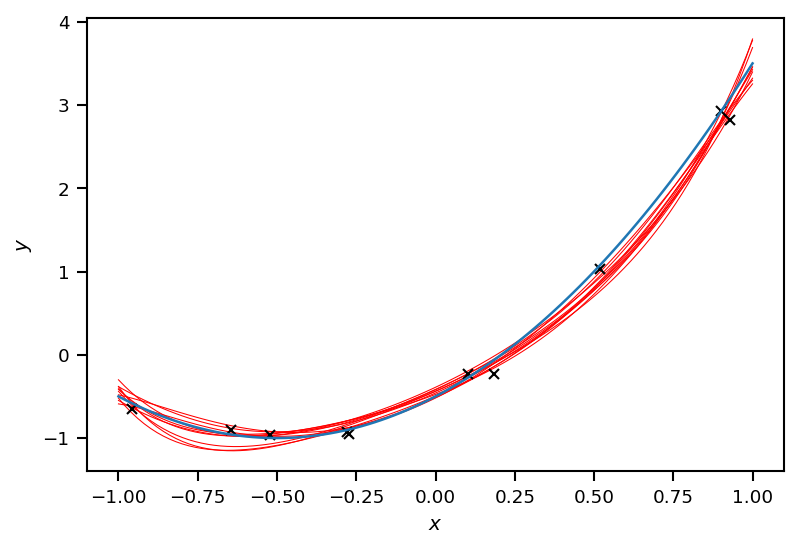

In [12]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case?

# Example 2

Training set of i.i.d. examples drawn from some unknown distribution.


$D = \{(x^{(i)}, y^{(i)})\}_{i=1}^{m}$

Testing set of i.i.d. examples drawn from the same distribution as S.


$T = \{(x^{(i)}_*, y^{(i)}_*)\}_{i=1}^{m}$

We have to fit this model

$\begin{align}
y^{(i)} = w^T x^{(i)} + \epsilon^{(i)} \\
\epsilon^{(i)} \sim \mathcal N (0, \sigma_n^2) \space \space i.i.d
\end{align}$

or in matrix form


$\mathbf y = \mathbf X^T \mathbf w + \epsilon$

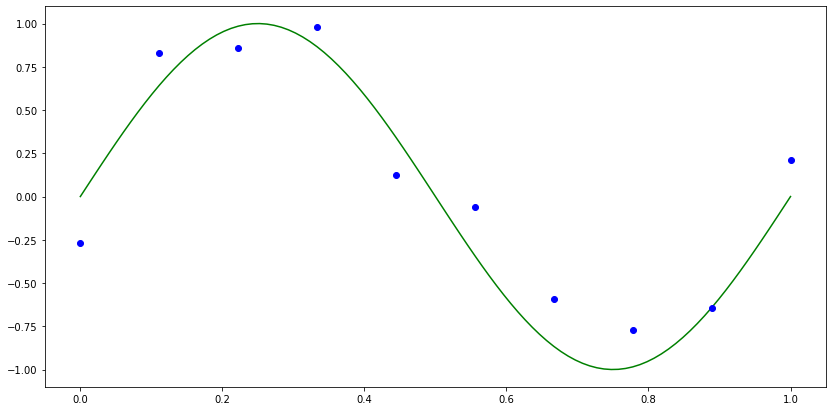

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

x_real = np.linspace(0, 1, 100, endpoint=True)
y_real = np.sin(2 * math.pi * x_real)
df_real = pd.DataFrame({'x':x_real, 'y':y_real})
plt.figure(figsize=(14,7))
plt.plot(x_real,y_real,'g-')

x = np.linspace(0, 1, 10, endpoint=True)
y = [np.sin(2 * math.pi * xi)+  np.random.uniform(-0.3,0.3) for xi in x]
df = pd.DataFrame({'x':x, 'y':y})
plt.plot(x,y,'bo')
plt.show()

# Bayesian Linear Regression

From

$\mathbf y = \mathbf X^T \mathbf w + \epsilon$


We can obtain the probability distribution of y by summing the probabilities of the right hand side, considering that 

$XTw=N(XwT,0)$

because it is supposedly the real value of the function, so it has variance 0.

$P(y|X,w)=N(XTw,0)+N(0,σ2n)$

$P(y|X,w)=N(XTw,σ2n)$


# Predicting a new "y"


We need to find the posterior; that is, the probability distribution of the x∗ for a new entry y∗


$p(y∗|x∗,X,y)$


# Bayes theorem

There's this assumption or prior 

$p(w)=N(0,Σp).$


And there's the likelihood of the data

Taking this into account, we can find $p(w|X,y)$, which according to Bayes theorem is

In the end, 

$p(w|X,y)=N(w|μw,Σw)=N(μw,Σw)$



# Nonlinear model


By using a mapping function for X, bayesian linear regression can work well with nonlinear curves.


$p(w|X,y)=N(μw,Σw)$

$μw=1σ2nΣ−1wΦyΣw=(1σ2nΦΦT+Σ−1p)−1$

and

$p(y∗|x∗,X,y)=N(μTwϕ(x∗),ϕ(x∗)TΣwϕ(x∗))$ 

considering the prior for the mean $m0=0$


In [11]:
# helper functions

def phi(x, M):
    return np.array([[x**i for i in range(M+1)]]).T

def matrix_S(x_vec, alpha, beta, M):
    first_expr = alpha*np.eye(M+1)
    second_expr = 0
    for n in range(len(x_vec)):
        second_expr += phi(x_vec[n], M).dot(phi(x_vec[n],M).T)
    return np.linalg.inv(first_expr+beta*second_expr)

def post_mean(x_new, x_vec, target_vec, S, alpha, beta, M):
    sum_vec_x = 0
    for i in range(len(x_vec)):
        sum_vec_x += phi(x_vec[i], M) * target_vec[i]
    return (beta * (phi(x_new, M).T.dot(S)).dot(sum_vec_x)).squeeze()

def post_variance(x_new, S, beta, M):
    return (1.0/beta + phi(x_new, M).T.dot(S).dot(phi(x_new, M))).squeeze()

def posterior(x_new, x_vec, target_vec, S, alpha, beta, M):
    return post_mean(x_new, x_vec, target_vec, S, alpha, beta, M), \
           post_variance(x_new, S, beta, M)

In [12]:
a = phi(2.,2)
np.dot(a, a.T)

array([[ 1.,  2.,  4.],
       [ 2.,  4.,  8.],
       [ 4.,  8., 16.]])

# Fit and predict
A train function or "fit" in scikit learn will only store the values of x and y in memory because unlike other type of learning algorithm, when having test data to evaluate, this method needs to consider the whole dataset again. As a consequence, "predicting" is a costly process.


Predicting a value

In [13]:
alpha = 5*10**(-3)
beta = 11.1
M = 9

x_new = 0.33

S = matrix_S(x, alpha, beta, M)
mean, variance = posterior(x_new, x, y, S, alpha, beta, M)
mean, variance

(array(0.78810344), array(0.1195303))

The mean is approximately the true value of y_new

# Plotting a confidence region around a expected function

In [14]:
means = [post_mean(x_i, x, y, S, alpha, beta, M) for x_i in x]
variances = [post_variance(x_i, S, beta, M) for x_i in x]

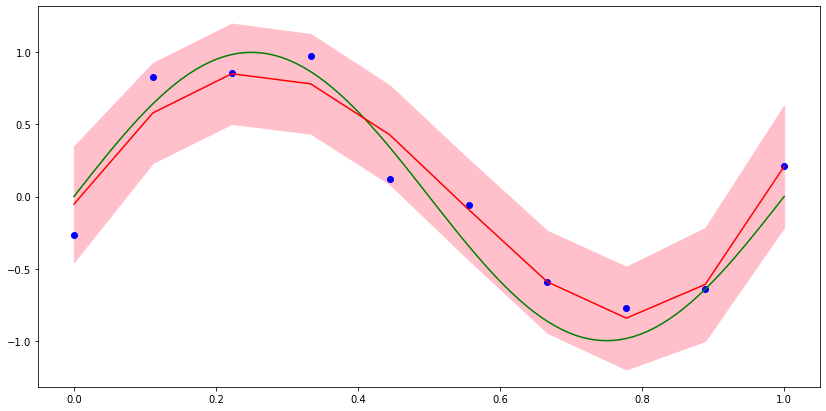

In [16]:
SD = np.sqrt(variances)
upper = means + SD
lower = means - SD

plt.figure(figsize=(14,7))
plt.plot(x, y, 'bo')
plt.plot(x_real, y_real, 'g-')
plt.plot(x, means, 'r-')
plt.fill_between(x, upper, lower, color='pink')
plt.show()